In [1]:
# Método para resolver las energías y eigenfunciones de un sistema cuántico numéricamente por Teoría de Pertubaciones
# Modelado Molecular 2
# By: José Manuel Casillas Martín     22-oct-2017
import numpy as np
from sympy import *
from sympy.physics.qho_1d import E_n, psi_n
from sympy.physics.hydrogen import E_nl, R_nl
from sympy import init_printing; init_printing(use_latex = 'mathjax')
from scipy import integrate
from scipy.constants import hbar, m_e, m_p, e
from mpmath import spherharm
from numpy import inf, array
import numpy as np
import matplotlib.pyplot as plt 
import traitlets
from IPython.display import display
from ipywidgets import Layout, Box, Text, Dropdown, Label, IntRangeSlider, IntSlider, RadioButtons

<h1><center>Teoría de Perturbaciones</center></h1>

Consiste en resolver un sistema perturbado(se conoce la solución al no perturbado), y donde el interés es conocer la contribución de la parte perturbada $H'$ al nuevo sistema total. 

$$ H = H^{0}+H'$$

La resolución adecuada del problema, depende en gran parte, de una correcta elección de $H'$.

In [2]:
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')

PType=Dropdown(options=['Particle in a one-dimensional box', 'Harmonic oscilator', 'Hydrogen atom (Helium correction)'])
Pert=Text()
Rang=IntRangeSlider(min=0, max=20, step=1, disabled=False, continuous_update=False, orientation='horizontal',\
                    readout=True, readout_format='d')
M=Text()
Correc=Dropdown(options=['1', '2'])
hbarra=Dropdown(options=[1, 1.0545718e-34])

form_items = [
    Box([Label(value='Problem'),PType], layout=form_item_layout),
    Box([Label(value='Perturbation'),Pert], layout=form_item_layout),
    Box([Label(value='Correction order'),Correc], layout=form_item_layout),
    Box([Label(value='n Range'),Rang], layout=form_item_layout),
    Box([Label(value='Mass'),M], layout=form_item_layout),
    Box([Label(value='Hbar'),hbarra], layout=form_item_layout),]

form = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='40%'))
form

En esta caja interactiva llena los datos del problema que deseas resolver.

# Nota 1:
Es recomendable usar unidades atómicas de Hartree para eficientar los cálculos. 1 u.a. (energía)= 27.211eV.

# Nota 2:
Para la partícula en una caja unidimensional es recomendable que n sea mayor o igual a 1.

## Nota 3:
Para la correción a la energía del átomo de Helio sólo es necesario seleccionar el problema, automáticamente se calcula la correción a primer orden y no se corrigen las funciones de onda.

In [3]:
Problem=PType.value
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')

L=Text()
W=Text()
atomic_number=RadioButtons(options=['1 (Show Hydrogen energies)','2 (Correct Helium first energy)'],disabled=False)

if Problem=='Particle in a one-dimensional box':
    form_items = [Box([Label(value='Large of box'),L], layout=form_item_layout)]

if Problem=='Harmonic oscilator':
    form_items = [Box([Label(value='Angular Fr'),W], layout=form_item_layout)]

if Problem=='Hydrogen atom (Helium correction)':
    form_items = [Box([Label(value='Atomic number'),atomic_number], layout=form_item_layout)]

form = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='40%'))
form

In [4]:
# Variables que se utilizarán
# x=variable de integracion, l=largo del pozo, m=masa del electrón, w=frecuencia angular
# n=número cuántico principal, Z=Número atómico, q=número cuántico angular(l)
var('x theta phi')
var('r1 r2', real=True)
var('l m hbar w n Z', positive=True, real=True)

# Perturbación
if Pert.value!='':
    H_p=sympify(Pert.value)
    h_p=eval(Pert.value)
else:
    H_p=0
    h_p=0

# Constantes
h=hbarra.value
a0=5.2917721067e-11
if M.value!='':
    mass=float(eval(M.value))
else:
    mass=1

# Energías y funciones que se desea corregir
n_inf=min(Rang.value)
n_sup=max(Rang.value)
    
if Problem=='Particle in a one-dimensional box':
    if L.value=='':
        large=1
    else:
        large=float(eval(L.value))
    omega=0
    # Energías del pozo de potencial infinito
    k=n*pi/l
    En=hbar**2*k**2/(2*m)
        
    # Funciones de onda del pozo de potencial infinito
    Psin=sqrt(2/l)*sin(n*pi*x/l)
    
    # Límites del pozo definido de 0 a l para sympy
    li_sympy=0
    ls_sympy=l
    # Mismo limites para scipy
    li_scipy=0
    ls_scipy=large

if Problem=='Harmonic oscilator':
    large=0
    if W.value=='':
        omega=1
    else:
        omega=float(eval(W.value))
    # Energías del oscilador armónico cuántico
    En=E_n(n,w)
    
    # Funciones de onda del oscilador armónico cuántico
    Psin=psi_n(n,x,m,w)

     # Límites del pozo definido de -oo a oo para sympy
    li_sympy=-oo
    ls_sympy=oo
    # Límites del pozo definido de -oo a oo para scipy
    li_scipy=-inf
    ls_scipy=inf
        
if Problem=='Hydrogen atom (Helium correction)':
    if atomic_number.value=='1 (Show Hydrogen energies)':
        z=1
    if atomic_number.value=='2 (Correct Helium first energy)':
        z=2
    large=0
    omega=0
    
    # Energías del átomo hidrogenoide
    En=z*E_nl(n,z)
    
    # Funciones de onda del átomo de hidrógeno
    # Número cuántico l=0
    q=0 # La variable l ya esta siendo utilizada para el largo de la caja por ello se sustituyo por q
    Psin=(R_nl(n,q,r1,z)*R_nl(n,q,r2,z))
    
     # Límites del átomo de hidrógeno de 0 a oo para sympy
    li_sympy=0
    ls_sympy=oo
    # Límites del átomo de hidrógeno de 0 a oo para scipy
    li_scipy=0
    ls_scipy=inf

Para sistemas no degenerados, la corrección a la energía a primer orden se calcula como 

$$ E_{n}^{(1)} = \int\psi_{n}^{(0)*} H' \psi_{n}^{(0)}d\tau$$

** Tarea 1 : Programar esta ecuación si conoces $H^{0}$ y sus soluciones. **

In [5]:
def correcion_1st_order_Energy(E_n,Psi_n,H_p,li,ls):
    E1_n=Integral(Psi_n*(H_p)*Psi_n,(x,li,ls)).doit()
    return(E_n+E1_n)

In [6]:
# Correción de la energía a primer orden
E=[]
Eev=[]
Ec1=[]
if Problem=='Particle in a one-dimensional box' or Problem=='Harmonic oscilator':
    for i in range(n_inf,n_sup+1):
        E.append(En.subs({n:i}))
        Eev.append(E[i-n_inf].subs({m:mass, l:large, hbar:h}).evalf())
        Ec1.append(correcion_1st_order_Energy(En.subs({n:i}),Psin.subs({n:i}),H_p,li_sympy,ls_sympy))
if Problem=='Hydrogen atom (Helium correction)':
    for i in range(n_inf,n_sup+1):
        E.append(En.subs({n:i}))
        Eev.append(E[i-n_inf])
    if z==2:
        integral_1=Integral(Integral((16*z**6*r1*r2**2*exp(-2*z*(r1+r2))),(r2,0,r1)),(r1,0,oo)).doit()
        integral_2=Integral(Integral((16*z**6*r1**2*r2*exp(-2*z*(r1+r2))),(r2,r1,oo)),(r1,0,oo)).doit()
        integral_total=(integral_1+integral_2)
        Ec1.append(E[0]+integral_total)

Y la corrección a la función de onda, también a primer orden, se obtiene como:

 $$ \psi_{n}^{(1)} = \sum_{m\neq n} \frac{\langle\psi_{m}^{(0)} | H' | \psi_{n}^{(0)} \rangle}{E_{n}^{(0)} - E_{m}^{(0)}} \psi_{m}^{(0)}$$

**Tarea 2: Programar esta ecuación si conoces $H^{0}$ y sus soluciones. **

In [7]:
# Correción de las funciones a primer orden
if Pert.value!='':
    if Problem=='Particle in a one-dimensional box' or Problem=='Harmonic oscilator':
        Psi_c=[]
        integrals=np.zeros((n_sup+1,n_sup+1))
        for i in range(n_inf,n_sup+1):
            a=0
            for j in range(n_inf,n_sup+1):
                if i!=j:
                    integ= lambda x: eval(str(Psin.subs({n:j})*(h_p)*Psin.subs({n:i}))).subs({m:mass,l:large,w:omega,hbar:h})
                    integrals[i,j]=integrate.quad(integ,li_scipy,ls_scipy)[0]
                    cte=integrals[i,j]/(En.subs({n:i,m:mass,l:large})-En.subs({n:j,m:mass,l:large})).evalf()
                    a=a+cte*Psin.subs({n:j})
            Psi_c.append(Psin.subs({n:i})+a)     

**Tarea 3: Investigue las soluciones a segundo orden y también programe las soluciones. **

Y la corrección a la energía a segundo orden, se obtiene como:

 $$  E_{n}^{(2)} = \sum_{m\neq n} \frac{|\langle\psi_{m}^{(0)} | H' | \psi_{n}^{(0)} \rangle|^{2}}{E_{n}^{(0)} - E_{m}^{(0)}} $$

In [8]:
# Correción a la energía a segundo orden
if Pert.value!='':
    if Problem=='Particle in a one-dimensional box' or Problem=='Harmonic oscilator':
        if Correc.value=='2':
            Ec2=[]
            for i in range(n_inf,n_sup+1):
                a=0
                for j in range(n_inf,n_sup+1):
                    if i!=j:
                        cte=((integrals[i,j])**2)/(En.subs({n:i,m:mass,l:large,hbar:h})-En.subs({n:j,m:mass,l:large,hbar:h})).evalf()
                        a=a+cte
                Ec2.append(Ec1[i-n_inf]+a) 

**A continuación se muestran algunos de los resultados al problema resuelto**

Las energías sin perturbación son:

In [9]:
E

⎡ℏ⋅w  3⋅ℏ⋅w  5⋅ℏ⋅w  7⋅ℏ⋅w⎤
⎢───, ─────, ─────, ─────⎥
⎣ 2     2      2      2  ⎦

La correción a primer orden de las energías son:

In [10]:
Ec1

⎡ℏ⋅w     ℏ    3⋅ℏ⋅w    3⋅ℏ   5⋅ℏ⋅w    5⋅ℏ   7⋅ℏ⋅w    7⋅ℏ ⎤
⎢─── + ─────, ───── + ─────, ───── + ─────, ───── + ─────⎥
⎣ 2    2⋅m⋅w    2     2⋅m⋅w    2     2⋅m⋅w    2     2⋅m⋅w⎦

Si seleccionaste en los parámetros iniciales una correción a segundo orden entonces...

Las correciones a la energía a segundo orden son:

In [11]:
Ec2

⎡ℏ⋅w   2.37063083491664e+33     ℏ    3⋅ℏ⋅w   7.11189250474994e+33    3⋅ℏ   5⋅ℏ
⎢─── - ──────────────────── + ─────, ───── - ──────────────────── + ─────, ───
⎣ 2             w             2⋅m⋅w    2              w             2⋅m⋅w    2

⋅w   2.37063083491664e+33    5⋅ℏ   7⋅ℏ⋅w   7.11189250474994e+33    7⋅ℏ ⎤
── + ──────────────────── + ─────, ───── + ──────────────────── + ─────⎥
              w             2⋅m⋅w    2              w             2⋅m⋅w⎦

Ahora vamos con la función de onda $(\psi)$

In [12]:
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between')

Graph=IntSlider(min=n_inf, max=n_sup, step=1, disabled=False, continuous_update=False, orientation='horizontal',\
                readout=True, readout_format='d')

form_items = [
    Box([Label(value='What function do you want to see?'),
         Graph], layout=form_item_layout)]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='40%'))
form

La función de onda original es:

In [13]:
Psin.subs({n:Graph.value})

                   2 
             -m⋅w⋅x  
             ────────
4 ___ 4 ___    2⋅ℏ   
╲╱ m ⋅╲╱ w ⋅ℯ        
─────────────────────
     4 ___ 4 ___     
     ╲╱ ℏ ⋅╲╱ π      

La correción a primer orden a la función de onda (utilizando todas las funciones en el rango seleccionado) es:

In [14]:
Psi_c[Graph.value-n_inf]

                                                                            2 
                   2                                                  -m⋅w⋅x  
             -m⋅w⋅x                                   ⎛       2    ⎞  ────────
             ────────                           4 ___ ⎜4⋅m⋅w⋅x     ⎟    2⋅ℏ   
4 ___ 4 ___    2⋅ℏ      8.38144569529743e+32⋅√2⋅╲╱ m ⋅⎜──────── - 2⎟⋅ℯ        
╲╱ m ⋅╲╱ w ⋅ℯ                                         ⎝   ℏ        ⎠          
───────────────────── - ──────────────────────────────────────────────────────
     4 ___ 4 ___                           4 ___ 4 ___  3/4                   
     ╲╱ ℏ ⋅╲╱ π                            ╲╱ ℏ ⋅╲╱ π ⋅w                      

Vamos a graficarlas para verlas mejor...

La función de onda original es:

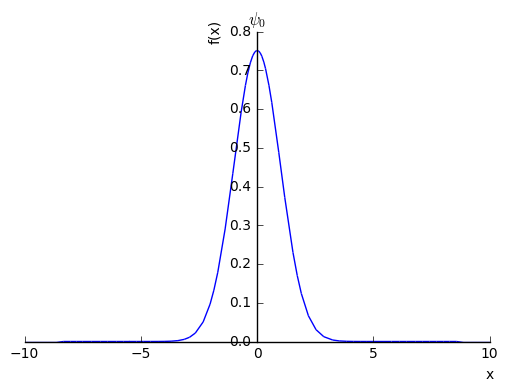

In [15]:
if Problem=='Particle in a one-dimensional box':
    plot(eval(str(Psin)).subs({n:Graph.value,m:mass,l:large,w:omega,hbar:h}),xlim=(li_scipy,ls_scipy),\
         title='$\psi_{%d}$'%Graph.value)
if Problem=='Harmonic oscilator':
    plot(eval(str(Psin)).subs({n:Graph.value,m:mass,l:large,w:omega,hbar:h}),xlim=(-10*h/(mass*omega),10*h/(mass*omega)),\
         title='$\psi_{%d}$'%Graph.value)
if Problem=='Hydrogen atom (Helium correction)':
    print('Densidad de probabilidad para un electrón')
    plot(eval(str((4*pi*x**2*R_nl(Graph.value,q,x,z)**2))),xlim=(0,10),ylim=(0,20/Graph.value), title='$\psi_{%ds}$'%Graph.value)
    print('Tome en cuenta que debido a la dificultad para seleccionar los límites de la gráfica se muestran bien los primeros\n\
3 estados. A partir de ahí visualizar la gráfica se complica.')

La corrección a la función de onda es:

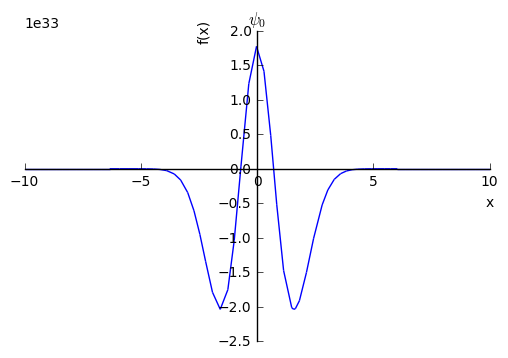

In [16]:
if Problem=='Particle in a one-dimensional box':
    if Pert.value!='':
        plot(eval(str(Psi_c[Graph.value-n_inf])).subs({n:Graph.value,m:mass,l:large,w:omega,hbar:h}),\
             xlim=(li_scipy,ls_scipy),title='$\psi_{%d}$'%Graph.value)
    if Pert.value=='':
        print('No se ingreso ninguna perturbación')
if Problem=='Harmonic oscilator':
    if Pert.value!='':
        plot(eval(str(Psi_c[Graph.value-n_inf])).subs({n:Graph.value,m:mass,l:large,w:omega,hbar:h}),\
             xlim=(-10*h/(mass*omega),10*h/(mass*omega)),title='$\psi_{%d}$' %Graph.value)
    if Pert.value=='':
        print('No se ingreso ninguna perturbación')
if Problem=='Hydrogen atom (Helium correction)':
    print('Este programa no corrige las fucniones de un átomo hidrogenoide')

**Tarea 4.  Resolver el átomo de helio aplicando los programas anteriores.** 

Para el cálculo a las correciones del átomo de Helio se tomó en cuenta lo siguiente...

La función de onda del átomo de Helio puede ser representada como:

$$ \psi_{nlm} = \psi(r1)_{nlm} \psi(r2)_{nlm}$$

Donde, para el estado fundamental:

$$ \psi(r_{1}.r_{2})_{100} = \frac{Z^{3}}{\pi a_{0}^{3}} e^{\frac{-Z}{a_{0}}(r_{1}+r_{2})}$$

Y la perturbación sería el término de repulsión entre los dos electrones, es decir:

$$ H'= \frac{e^{2}}{r_{12}}=\frac{e^{2}}{|r_{1}-r_{2}|}$$

Finalmente la correción a primer orden de la energía sería:
    
$$ E^{(1)}= \langle\psi_{n}^{(0)} | H' | \psi_{n}^{(0)} \rangle =\frac{Z^{6}e^{2}}{\pi^{2} a_{0}^{6}} \int_{0}^{2\pi}\int_{0}^{2\pi}\int_{0}^{\pi}\int_{0}^{\pi}\int_{0}^{\infty}\int_{0}^{\infty} \frac{e^{\frac{-2Z}{a_{0}}(r_{1}+r_{2})}}{r_{12}} r_{1}^{2}r_{2}^{2}sen{\theta_{1}}sen{\theta_{2}} dr_{2} dr_{1} d\theta_{2} d\theta_{1} d\phi_{2} d\phi_{1}$$

Se utiliza una expansión del termino de repulsión con los armónicos esféricos y se integra la parte angular. Una vez hecho eso, la integral queda expresada de la siguiente manera:

$$ E^{(1)}= \frac{16Z^{6}e^{2}}{a_{0}^{6}} \left[\int_{0}^{\infty} r_{1}^{2} e^{\frac{-2Z}{a_{0}}r_{1}} \left(\int_{0}^{r_{1}} \frac{r_{2}^{2}}{r_{1}} e^{\frac{-2Z}{a_{0}}r_{2}} dr_{2}+\int_{r_{1}}^{\infty}r_{2} e^{\frac{-2Z}{a_{0}}r_{2}}dr_{2}\right) dr_{1} \right]$$

Esta fue la integral que se programó para hacer la correción a la energía del Helio

**Tarea 5: Método variacional-perturbativo. **

Este método nos permite estimar de forma precisa $E^{(2)}$ y correcciones perturbativas de la energía de órdenes más elevados para el estado fundamental del sistema, sin evaluar sumas infinitas. Ver ecuación 9.38 del libro. 

$$ \langle u | H^{0} - E_{g}^{(0)} | u \rangle + \langle u | H' - E_{g}^{(1)} | \psi_{g}^{(0)} \rangle +\langle\psi_{g}^{(0)} | H' - E_{g}^{(1)} | u \rangle \geq E_{g}^{(2)} $$

Donde:

u, es cualquier función que se comporte bien y satisfaga condiciones de frontera.

Por lo general, u tiene un parámetro variacional que permite minimizar el lado izquierdo de la ecuación para estimar $E_{g}^{(2)} $. La función u resulta ser una aproximación a $\psi_{g}^{(1)}$, por lo que se puede utilizar está misma función para estimar $E_{g}^{(3)}$ y seguir haciendo iteraciones para hacer correciones de orden superior tanto a la energía como a la función de onda.

Es necesario meter parámetros de optimización a las funciones de prueba para que tenga sentido intentar programar esto. Esto nos limita a usar Sympy para resolver la integral simbólicamente. Entonces, estamos limitados a las capacidades de esta librería para resolver las integrales y a la capacidad de nuestro procesador. Ya corroboramos que un intel I-7 es cerca de 10 veces más rápido que un I-5.

A continuación se muestra un código que, aprovechando los datos introducidos anteriormente, encuentra por medio del método variacional-perturbativo la correción a segundo orden de la energía y a primer orden de la función de onda.

In [17]:
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')

F_prueba=Text()
Ran_n=IntSlider(min=n_inf, max=n_sup, step=1, disabled=False, continuous_update=False, orientation='horizontal',\
                    readout=True, readout_format='d')
Correcc=RadioButtons(options=[2],disabled=False)

form_items = [
    Box([Label(value='Test function'),F_prueba], layout=form_item_layout),
    Box([Label(value='Correction order'),Correcc], layout=form_item_layout),
    Box([Label(value='Function to correct'),Ran_n], layout=form_item_layout),]

form = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='40%'))
form

Para la función de prueba se espera que el usuario introduzca una función que sea cuadrado-integrable y que sea compatible en las fronteras con el tipo de problema que se esta solucionando. Además, puede intruducir una constante de optimización (utilice "c")

In [47]:
# Variables que se utilizarán
# c y d=constantes de optimización
var('c')#, real=True)

u=eval(F_prueba.value)
order=Correcc.value
n_n=Ran_n.value

if Problem=='Particle in a one-dimensional box':
    V=0
    
if Problem=='Harmonic oscilator':
    V=(m/2)*w**2*x**2
    
if Problem=='Particle in a one-dimensional box' or Problem=='Harmonic oscilator':
    integrando_a=(u)*((-hbar**2)/(2*m)*diff(u,x,2))+(u)*V*(u)-(u)*En.subs({n:n_n})*(u)
    integrando_b=(u)*h_p*(Psin.subs({n:n_n}))-(u)*(Ec1[n_n-n_inf]-En.subs({n:n_n}))*(Psin.subs({n:n_n}))
    integral_a=Integral(eval(str(integrando_a)),(x,li_sympy,ls_sympy)).doit()
    integral_b=Integral(eval(str(integrando_b)),(x,li_sympy,ls_sympy)).doit()
    integral_T=integral_a+2*integral_b
    f_opt=diff(integral_T,c,1)
    c2=solve(f_opt,c)
    E_c2=Ec1[n_n-n_inf]+integral_T.subs({c:c2[0]})
    Psi_c1=(Psin.subs({n:n_n})+u.subs({c:c2[0]}))

Se considero que para fines de esta tarea que:

 $$\langle u | H' - E_{g}^{(1)} | \psi_{g}^{(0)} \rangle =\langle\psi_{g}^{(0)} | H' - E_{g}^{(1)} | u \rangle$$

Lo cual se cumple cuando $H'$ es una función sin operadores diferenciales, y además, u y $\psi_{g}^{(0)}$ son funciones reales.

Las correciones a la energía son:

In [56]:
E[n_n-n_inf]

ℏ⋅w
───
 2 

In [57]:
Ec1[n_n-n_inf]

ℏ⋅w     ℏ  
─── + ─────
 2    2⋅m⋅w

In [58]:
E_c2

                     0.25   1.0  -2.0  -3.0   0.141047395886939⋅√π⋅h̅   ℏ⋅w   
- 0.375562772232471⋅π    ⋅h̅   ⋅m    ⋅w     + ─────────────────────── + ─── + 
                                                        2  3             2    
                                                       m ⋅w                   

  ℏ  
─────
2⋅m⋅w
     

Las correción a la función de onda:

In [59]:
Psin.subs({n:n_n})

                   2 
             -m⋅w⋅x  
             ────────
4 ___ 4 ___    2⋅ℏ   
╲╱ m ⋅╲╱ w ⋅ℯ        
─────────────────────
     4 ___ 4 ___     
     ╲╱ ℏ ⋅╲╱ π      

In [60]:
Psi_c1

                   2                                      2 
             -m⋅w⋅x                                 -m⋅w⋅x  
             ────────                               ────────
4 ___ 4 ___    2⋅ℏ                        4 ___  2    2⋅h̅  
╲╱ m ⋅╲╱ w ⋅ℯ           0.375562772232471⋅╲╱ m ⋅x ⋅ℯ        
───────────────────── - ────────────────────────────────────
     4 ___ 4 ___                       5/4  3/4             
     ╲╱ ℏ ⋅╲╱ π                      h̅   ⋅w                

Veamos ahora las gráficas de estas funciones...

La función de onda original es:

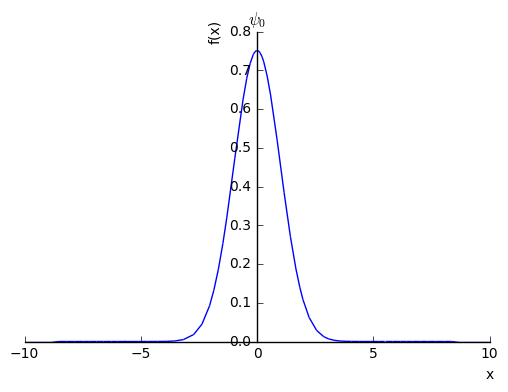

In [61]:
if Problem=='Particle in a one-dimensional box':
    plot(eval(str(Psin)).subs({n:n_n,m:mass,l:large,w:omega,hbar:h}),xlim=(li_scipy,ls_scipy),\
         title='$\psi_{%d}$'%n_n)
if Problem=='Harmonic oscilator':
    plot(eval(str(Psin)).subs({n:n_n,m:mass,l:large,w:omega,hbar:h}),xlim=(-10*h/(mass*omega),10*h/(mass*omega)),\
         title='$\psi_{%d}$'%n_n)

Su correción por medio del método variacional-perturbativo es:

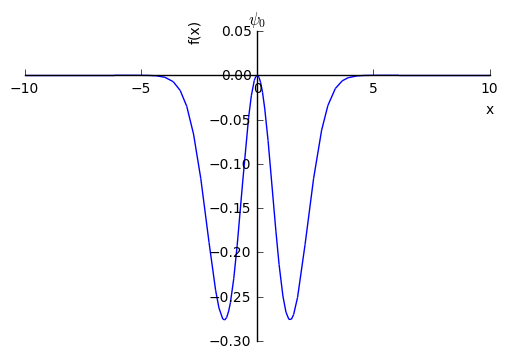

In [62]:
if Problem=='Particle in a one-dimensional box':
    if Pert.value!='':
        plot(Psi_c1.subs({m:mass,l:large,w:omega,hbar:h}),\
             xlim=(li_scipy,ls_scipy),ylim=(-1.5,1.5),title='$\psi_{%d}$'%n_n)
    if Pert.value=='':
        print('No se ingreso ninguna perturbación')
if Problem=='Harmonic oscilator':
    if Pert.value!='':
        plot(Psi_c1.subs({m:mass,l:large,w:omega,hbar:h}),\
             xlim=(-10*h/(mass*omega),10*h/(mass*omega)),title='$\psi_{%d}$' %n_n)

**Tarea 6. Revisar sección 9.7. **

Inicialmente a mano, y sengunda instancia favor de intentar programar sección del problema, i.e. integral de Coulomb  e integral de intercambio.

Para comenzar a solucionar este problema, es necesario ser capaz de escribir el termino de repulsión que aparece en la fuerza culombiana ($\frac {1} {r_{12} }$) en términos de los armónicos esféricos de la siguiente manera:

$$ \frac {1} {r_{12} } = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} \frac{4\pi}{2l+1} \frac{r_{<}^{l}}{r_{>}^{l+1}}  \left[Y_{l}^{m}(\theta_{1},\phi_{1})  \right]^{*} Y_{l}^{m}(\theta_{2},\phi_{2})  $$

Intentar programar esto se complica, puesto que los armónicos esféricos sólo han sido definido en librerias de python de forma numérica. Si intentamos programar los armónicos de manera simbólica es necesario utilizar las Polinomios asociados de Legendre, que de igual manera, sólo han sido definidos de manera numérica.

Se podría intentar programar las integral de intercambio de forma numérica pero hacerlo de forma simbólica permitiría simplificar mucho los cálculos, porque al integrar los armónicos esféricos aparecen $\delta_{l,l'}$ y $\delta_{m,m'}$, por lo que la mayoría de las integrales se hacen $0$.

Aún cuando se lograra programar todo esto, hace falta verificar que se seleccionaron correctamente los límites de integración radiales para que el término $\frac{r_{<}^{l}}{r_{>}^{l+1}}$ haga sentido.